#### Data Science techniques
A collection of data science techniques for practicing for interviews. This notebook consists of the following:

#### Trees
* Classification tree
* Regression tree
* Random forest or bagging (parallel ensemble)
* Boosting (sequential ensemble)
* Bagging vs Boosting 

Start with [boosting](https://www.python-course.eu/Boosting.php)

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

In [79]:
'''Before Boosting: 
1. Encode letters in each column to a numeric value
2. Get baseline accuracy with a simple classification tree, with max_depth=1
'''
dataset = pd.read_csv('data/mushrooms.csv',header=None);
colnames = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
             'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
             'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population',
             'habitat']
for col in dataset.columns:
    dataset[col] = LabelEncoder().fit(dataset[col]).transform(dataset[col]);
dataset.columns = colnames; 
dataset.head()

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,2,0,2,0,6,2,1,1,3,...,3,7,7,1,2,2,5,6,3,2
1,2,6,3,5,2,7,1,0,2,5,...,2,8,8,0,3,1,4,2,4,6
2,1,6,3,10,2,0,1,0,0,5,...,2,8,8,0,3,1,4,3,2,1
3,1,0,3,9,2,3,1,0,0,6,...,2,8,8,0,3,1,4,3,2,4
4,2,6,4,9,2,7,1,0,2,6,...,2,8,8,0,3,1,4,2,4,6


In [80]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1);
X=dataset.drop(['target'],axis=1);
y=dataset['target'].where(dataset['target']==1,-1)
test_acc = np.mean(cross_validate(tree, X, y, cv=100)['test_score']); 
print(f'CV accuracy with 1 depth tree: {test_acc*100:0.2f}%')

CV accuracy with 1 depth tree: 73.12%


In [81]:
class Boosting:
    def __init__(self,dataset, T, test_dataset):
        self.dataset = dataset;
        self.T=T;
        self.test_dataset = test_dataset;
        self.alphas=None;
        self.models=None;
        self.accuracy = [];
        self.predictions=None;
    
    def fit(self):
        X=dataset.drop(['target'],axis=1)
        y=dataset['target'].where(dataset['target']==1,-1)
        
        evaluation = pd.DataFrame(y.copy());
        evaluation['weights']=1/len(self.dataset);
        
        alphas = []; models=[];
        for t in range(self.T):
            tree = DecisionTreeClassifier(criterion='entropy', max_depth=1);
#             print(evaluation)
            model = tree.fit(X,y,sample_weight=np.array(evaluation['weights']));
            models.append(model);
            
            evaluation['predictions'] = model.predict(X);
            evaluation['misclassified'] = np.where(evaluation['predictions'] != y,1,0);
            
            err = np.sum(evaluation['weights']*evaluation['misclassified'])/np.sum(evaluation['weights'])
            
            alpha = np.log((1-err)/err);
            alphas.append(alpha);
            
            evaluation['weights'] *= np.exp(alpha*evaluation['misclassified']);
#             print(evaluation['weights'])
        self.alphas = alphas;
        self.models = models;
        
    def predict(self):
        X_test = self.test_dataset.drop('target',axis=1)
        y_test = self.test_dataset['target'].where(self.test_dataset['target']==1,-1)
        
        accuracy, predictions = [],[];
        
        for alpha, model in zip(self.alphas, self.models):
            pred = alpha*model.predict(X_test);
            predictions.append(pred);
#             pred = np.sum(np.sign(np.sum(np.array(pred),axis=0) == y_test.values)/len(predictions[0]))
#             self.accuracy.append(pred)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==y_test.values)/len(predictions[0]))
            
            self.predictions = np.sign(np.sum(np.array(predictions),axis=0))


100%|██████████| 50/50 [00:11<00:00,  2.15it/s]


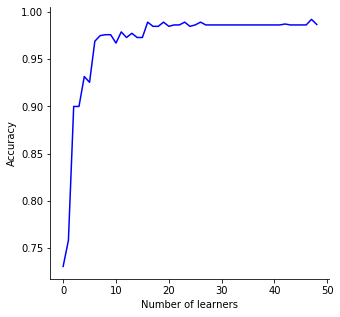

In [82]:
number_of_base_learners = 50

fig,ax = plt.subplots(figsize=(5,5))
for i in tqdm(range(number_of_base_learners)):
    model = Boosting(dataset,i,dataset)
    model.fit()
    model.predict()

ax.plot(model.accuracy,'-b'); ax.set_xlabel('Number of learners'); 
ax.set_ylabel('Accuracy'); sns.despine();
plt.show()

So in essence, boosting fits a tree to all samples where the "importance" of a particular sample is decided by the classification error in the last iteration AND whether or not that particular sample was misclassified. So, even though this method is similar to the Random Forest approach in that it builds and ensemble of models, it is different since every $n^{th}$ model is an improvement over the previous $(n-1)^{th}$ model.

Now that I have coded it from scratch, it's time to use sklearn's toolkit

In [83]:
from sklearn.ensemble import AdaBoostClassifier

In [84]:
ada = AdaBoostClassifier(n_estimators=50,learning_rate=1,algorithm='SAMME');
ada.fit(X,y);
prediction = ada.score(X,y);
print(f'Accuracy from AdaBoost sklearn: {prediction*100:0.2f}')

Accuracy from AdaBoost sklearn: 99.85


#### Random forest classifier [(Bagging)](https://www.python-course.eu/Random_Forests.php)
This is a mixture of two processes:
* Bootstrapped data
    - The samples are bootstrapped to build separate trees
* Aggregation
    - Each bootstrapped dataset is fit with a sub-sampled set of features. This subsampling helps us get rid of very strong correlated features

In [85]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=50,criterion='entropy',max_depth=1);

rf_score = random_forest.fit(X,y).score(X,y); 
print(f'Random forest accuracy: {rf_score*100:0.2f}')

Random forest accuracy: 91.62


#### When to use Bagging vs Boosting?

Bagging and Boosting are both ensemble methods, i.e., they both make multiple trees and the aggregated results from all models are used to make predictions.

Boosting is typically useful to get high performance but it might lead to over-fitting. Bagging, on the other hand, might not necessarily improve training performance by much but helps avoid over-fitting.

A very intuitive visualization is shown [on this page](https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/)